# Hands-On Exercises: Fine-Tuning SmolVLM2-2.2B-Instruct

Welcome to the practical section! Here you'll put into practice everything you've learned about vision language models (VLMs) using **HuggingFaceTB/SmolVLM2-2.2B-Instruct**.  
The exercises progress from foundational concepts to advanced techniques, helping you gain real-world, hands-on experience.

## Learning Objectives

By the end of these exercises, you will be able to:

- **Work with VLM datasets**: Explore and prepare **HuggingFaceM4/ChartQA**.  
- **Optimize training**: Apply **quantization** and **PEFT** for efficient fine-tuning.  
- **Fine-tune models in practice**: Train **HuggingFaceTB/SmolVLM2-2.2B-Instruct** using both Python APIs and CLI tools.  
- **Adapt datasets for TRL**: Prepare VLM datasets to integrate seamlessly with TRL workflows.  
- **Move to production**: Understand how to scale and manage **production-ready fine-tuning workflows** for VLMs.

## Exercise 1: Explore `SmolVLM2-2.2B-Instruct`

**Objective:** Get familiar with the `SmolVLM2-2.2B-Instruct` model and evaluate the model using a sample from the dataset.

### Environment Setup

<Tip warning={true}>

- You need a GPU with at least 8GB VRAM for training. CPU/MPS can run formatting and dataset exploration, but training larger models will likely fail.
- First run will download several GB of model weights; ensure 15GB+ free disk and a stable connection.
- If you need access to private repos, authenticate with Hugging Face Hub via `login()`.

</Tip>

First, install the required libraries: `transformers`, `datasets`, `trl`,`huggingface_hub`, and `trackio`.  
These packages provide the tools for working with the model, datasets, and Hugging Face Hub.  

In [ ]:
# Install required packages (run in Colab or your environment)
!pip install transformers datasets trl huggingface_hub trackio num2words==0.5.14

### Import dependencies

Now, import the main dependencies we'll use:

In [2]:
# Import dependencies

import torch
import os
from transformers import AutoProcessor, AutoModelForImageTextToText, BitsAndBytesConfig
from transformers.image_utils import load_image

### Load the model and processor

#### 1. Select the device  

We start by selecting the device where the model will run. It can be a GPU (`cuda`), Apple Silicon (`mps`), or the CPU as a fallback.


In [3]:
device = (
    "cuda"
    if torch.cuda.is_available()
    else "mps" if torch.backends.mps.is_available() else "cpu"
)

#### 2. Authenticate with Hugging Face

To work with private models or to **push your fine-tuned model to the Hub** (as we'll do in this exercise), you need to authenticate with your Hugging Face account.

<Tip>

You can create and copy your access token from the [Hugging Face tokens page](https://huggingface.co/settings/tokens) in your profile.

</Tip>

In [ ]:
from huggingface_hub import login
login()

#### 3. Load the model and processor

Finally, we load the **HuggingFaceTB/SmolVLM2-2.2B-Instruct** model.
The `AutoProcessor` is also initialized here — it ensures that both text and images are preprocessed correctly before being passed to the model.

In [ ]:
model_name = "HuggingFaceTB/SmolVLM2-2.2B-Instruct"
model = AutoModelForImageTextToText.from_pretrained(
    model_name,
    dtype=torch.bfloat16,
).to(device)

processor = AutoProcessor.from_pretrained(model_name)

### Explore the dataset

In this step, we load a small subset of the **ChartQA** dataset — just 10% of the training and validation splits — to keep the exercises fast and manageable for learning purposes.

We then display one of the chart images using `matplotlib` to get a visual sense of the model's input.  
Additionally, we print the corresponding query and label so you can fully understand the dataset structure and the type of tasks the model will handle.

In [6]:
from IPython.display import IFrame

IFrame(
    src="https://huggingface.co/datasets/HuggingFaceM4/ChartQA/embed/viewer/default/train",
    width="100%",
    height=560
)

In [ ]:
from datasets import load_dataset
import matplotlib.pyplot as plt

train_dataset, eval_dataset = load_dataset("HuggingFaceM4/ChartQA", split=["train[:10%]", "val[:10%]"])
example = train_dataset[1]
image = load_image(example["image"])

print(example["query"])
print(example["label"][0])

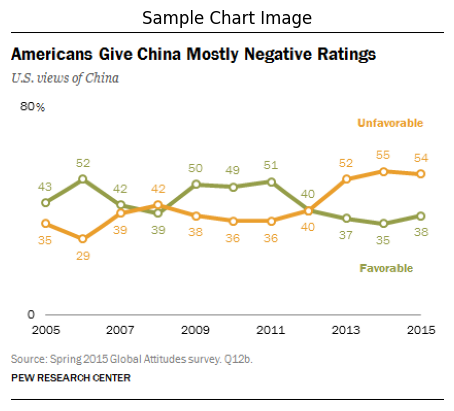

In [8]:
plt.imshow(image)
plt.axis("off")
plt.title("Sample Chart Image")
plt.show()

### Build a chat-style prompt

We create a **chat message list** that includes a user query along with the image.

Using `processor.apply_chat_template`, we transform this into the exact input format the model expects.

In [ ]:
# Define a chat-style prompt
messages = [
    {"role": "user", "content": [
        {"type": "image", "image": image},
        {"type": "text", "text": example["query"]},
    ]}
]

# Apply the chat template
chat_prompt = processor.apply_chat_template(
      messages, add_generation_prompt=True\
)
print(chat_prompt)

### Run inference

We tokenize the chat prompt and image into tensors, then generate a response with the model.
Finally, we decode the output tokens back into text.

In [ ]:
# Tokenize input
inputs = processor(images=[image], text=chat_prompt, return_tensors="pt").to(device)

# Generate model output
with torch.no_grad():
    output = model.generate(**inputs, max_new_tokens=20)

# Trim the generated ids to remove the input ids
trimmed_generated_ids = [out_ids[len(in_ids) :] for in_ids, out_ids in zip(inputs.input_ids, output)]

# Decode the output text
output_text = processor.batch_decode(
    trimmed_generated_ids, skip_special_tokens=True, clean_up_tokenization_spaces=False
)
print(output_text[0])

The model generates a reponse, but it's not exactly correct. It could be improved with some fine-tuning. Now that we've seen how to build prompts and generate responses with **SmolVLM2-2.2B-Instruct**, it's time to learn how to adapt and **fine-tune** the model efficiently using **LoRA (Low-Rank Adaptation)**. This approach allows training large models with fewer resources and prepares the model for specific downstream tasks.


## Exercise 2: Fine-Tune the Model Using LoRA

In this exercise, we'll apply **LoRA (Low-Rank Adaptation)** to fine-tune our Vision-Language Model efficiently.  

LoRA works by injecting **trainable low-rank matrices** into existing model layers, enabling **large models to be fine-tuned with significantly fewer trainable parameters**.  
This approach reduces memory usage and speeds up training while maintaining high performance.

### Format dataset

The first step involves formatting the dataset for VLM training. We'll create a system message to make the VLM act as a chart analysis expert, giving concise answers about chart images.

In [14]:
system_message = """You are a Vision Language Model specialized in interpreting visual data from chart images.
Your task is to analyze the provided chart image and respond to queries with concise answers, usually a single word, number, or short phrase.
The charts include a variety of types (e.g., line charts, bar charts) and contain colors, labels, and text.
Focus on delivering accurate, succinct answers based on the visual information. Avoid additional explanation unless absolutely necessary."""

We'll format the dataset into a chatbot structure, with the system message, image, user query, and answer for each interaction. This dataset format is expect by the `SFTTrainer`, includind the `images` and `messages` columns. You can learn more about formatting the datasets for VLM post training in the [docs](https://huggingface.co/docs/trl/en/sft_trainer#training-vision-language-models).

In [15]:
def format_data(sample):
    return {
        "images": [sample["image"]],
        "messages": [
            {
                "role": "system",
                "content": [{"type": "text", "text": system_message}],
            },
            {
                "role": "user",
                "content": [
                    {
                        "type": "image",
                        "image": sample["image"],
                    },
                    {
                        "type": "text",
                        "text": sample["query"],
                    },
                ],
            },
            {
                "role": "assistant",
                "content": [{"type": "text", "text": sample["label"][0]}],
            },
        ],
    }

Now, let’s format the data using the chatbot structure. This will set up the interactions for the model.

In [16]:
train_dataset = [format_data(sample) for sample in train_dataset]
eval_dataset = [format_data(sample) for sample in eval_dataset]


### Configure LoRA

Here we define a `LoraConfig`:
- `r` and `lora_alpha` control the rank and scaling of the adaptation matrices.
- `target_modules` specifies which parts of the model to adapt.
- `task_type` is set for causal language modeling.

We then apply LoRA to the base model using `get_peft_model` and print out the trainable parameters to verify the adaptation.

In [ ]:
from peft import LoraConfig, get_peft_model

# Configure LoRA
peft_config = LoraConfig(
    lora_alpha=16,
    lora_dropout=0.05,
    r=8,
    target_modules=["q_proj", "v_proj"],
    task_type="CAUSAL_LM",
)

# Apply PEFT model adaptation
peft_model = get_peft_model(model, peft_config)

# Print trainable parameters
peft_model.print_trainable_parameters()

### Set up the Trainer

We configure the **SFTTrainer** from `trl` with `SFTConfig`:
- `num_train_epochs`, `batch_size`, and `gradient_accumulation_steps` control the training loop.
- `gradient_checkpointing`, and `bf16` optimize memory and speed.
- `learning_rate` manages optimization.
- `train_dataset` and `eval_dataset` are aligned with your dataset.

This prepares the trainer to handle fine-tuning with PEFT/LoRA.

In [ ]:
from trl import SFTConfig, SFTTrainer

# Configure training arguments using SFTConfig
training_args = SFTConfig(
    output_dir="smol-course-SmolVLM2-2.2B-Instruct-trl-sft-ChartQA",
    num_train_epochs=1,
    per_device_train_batch_size=4,
    gradient_accumulation_steps=4,
    learning_rate=1e-4,
    logging_steps=25,
    save_strategy="steps",
    save_steps=25,
    optim="adamw_torch_fused",
    bf16=True,
    push_to_hub=True,
    report_to="trackio",
    max_length=None,
)

# Initialize the Trainer
trainer = SFTTrainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=eval_dataset,
    peft_config=peft_config,
)

# Align the SFTTrainer params with your chosen dataset.

### Train and Save the Model

Now we run the training loop:
1. `trainer.train()` starts fine-tuning with LoRA.
2. `trainer.save_model()` stores the locally trained model.

This step ensures the model is ready for downstream tasks with minimal additional parameters.

In [ ]:
# Train the model
trainer.train()

# Save the model
trainer.save_model(training_args.output_dir)